In [2]:
import numpy as np
import keras
from keras import Sequential
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from first_test import EVENT_DICT
import class_count

In [3]:
dev_x = np.load('wpd/dev_x.npy')
dev_y = np.load('wpd/dev_y.npy')
eval_x = np.load('wpd/eval_x.npy')
eval_y = np.load('wpd/eval_y.npy')
train_x = np.load('wpd/train_x.npy')
train_y = np.load('wpd/train_y.npy')
mysz_extra = np.load('extra_samples/gan_generated/mysz_extra_samples.npy')
tcsz_extra = np.load('extra_samples/gan_generated/tcsz_extra_samples.npy')
tnsz_extra = np.load('extra_samples/gan_generated/tnsz_extra_samples.npy')

In [4]:
def create_labels(label_name, samples_length=1000):
    label_array = list()
    for i in range(samples_length):
        label_array.append(label_name)
    return np.array(label_array)

mysz_labels = create_labels('mysz')
tcsz_labels = create_labels('tcsz')
tnsz_labels = create_labels('tnsz')

In [5]:
def instance_deconcat(np_array, points_size=1024):
    final_x = list()
    for i in range(len(np_array)):
        opt_array = list()
        opt_array.append(np_array[i, : points_size])
        for j in range(1, 22):
            opt_array.append(np_array[i, points_size*j:points_size*(j+1)])
        final_x.append(opt_array)
    return np.array(final_x)

In [6]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
])

In [7]:
x_train_scaled = pipeline.fit_transform(train_x)
x_eval_scaled = pipeline.transform(eval_x)
x_dev_scaled = pipeline.transform(dev_x)

In [8]:
train_x_scaled = instance_deconcat(x_train_scaled, 112)
eval_x_scaled = instance_deconcat(x_eval_scaled, 112)
dev_x_scaled = instance_deconcat(x_dev_scaled, 112)

In [9]:
print(train_x_scaled.shape)
print(eval_x_scaled.shape)
print(dev_x_scaled.shape)
print(mysz_extra.shape)

(111920, 22, 112)
(6533, 22, 112)
(21522, 22, 112)
(1000, 22, 112)


In [10]:
eval_count = class_count.class_count_array(eval_y)
print(eval_count)
dev_count = class_count.class_count_array(dev_y)
print(dev_count)
train_count = class_count.class_count_array(train_y)
print(train_count)

{'fnsz': 1835, 'gnsz': 2911, 'spsz': 0, 'cpsz': 528, 'absz': 1078, 'tnsz': 7, 'cnsz': 0, 'tcsz': 167, 'mysz': 0, 'bckg': 7}
{'fnsz': 3553, 'gnsz': 11654, 'spsz': 0, 'cpsz': 34, 'absz': 327, 'tnsz': 21, 'cnsz': 0, 'tcsz': 47, 'mysz': 0, 'bckg': 5886}
{'fnsz': 8238, 'gnsz': 6544, 'spsz': 942, 'cpsz': 1562, 'absz': 1099, 'tnsz': 380, 'cnsz': 0, 'tcsz': 573, 'mysz': 42, 'bckg': 92540}


In [11]:
mysz_train_index = np.where(train_y == 'mysz')[0][:14]
spsz_train_index = np.where(train_y == 'spsz')[0][:14]

In [46]:
undersampling_seizure_labels = ['fnsz', 'gnsz', 'bckg']
normal_seizure_labels = ['spsz', 'cpsz', 'absz', 'tnsz', 'tcsz', 'mysz']

def get_new_train(undersampling_labels=undersampling_seizure_labels, normal_labels=normal_seizure_labels):
    undersampling_dict = {'fnsz': 0, 'gnsz': 0, 'bckg': 0}
    new_train_x = list()
    new_train_y = list()
    for i in range(len(train_y)):
        if train_y[i] in undersampling_labels and undersampling_dict[train_y[i]] <= 1600:
            new_train_x.append(train_x_scaled[i])
            new_train_y.append(train_y[i])
            undersampling_dict[train_y[i]] += 1
        elif train_y[i] in normal_labels and i not in mysz_train_index and i not in spsz_train_index:
            new_train_x.append(train_x_scaled[i])
            new_train_y.append(train_y[i])
    return np.array(new_train_x), np.array(new_train_y)

def get_new_eval(undersampling_labels=undersampling_seizure_labels, normal_labels=normal_seizure_labels):
    undersampling_dict = {'fnsz': 0, 'gnsz': 0, 'bckg': 0}
    new_eval_x = list()
    new_eval_y = list()
    for i in range(len(eval_y)):
        if eval_y[i] in undersampling_labels and undersampling_dict[eval_y[i]] <= 500:
            new_eval_x.append(eval_x_scaled[i])
            new_eval_y.append(eval_y[i])
            undersampling_dict[eval_y[i]] += 1
        elif eval_y[i] in normal_labels:
            new_eval_x.append(eval_x_scaled[i])
            new_eval_y.append(eval_y[i])
    new_eval_x = np.array(new_eval_x)
    new_eval_y = np.array(new_eval_y)

    mysz_indexes = mysz_train_index[:7]
    spsz_indexes = spsz_train_index[:7]
    new_instances = list()
    new_labels = list()
    for i in mysz_indexes:
        new_instances.append(train_x_scaled[i])
        new_labels.append(train_y[i])
    for i in spsz_indexes:
        new_instances.append(train_x_scaled[i])
        new_labels.append(train_y[i])

    new_eval_x = np.append(new_eval_x, np.array(new_instances), axis=0)
    new_eval_y = np.append(new_eval_y, np.array(new_labels))

    return new_eval_x, new_eval_y

def get_new_dev(undersampling_labels=undersampling_seizure_labels, normal_labels=normal_seizure_labels):
    undersampling_dict = {'fnsz': 0, 'gnsz': 0, 'bckg': 0}
    new_dev_x = list()
    new_dev_y = list()
    for i in range(len(dev_y)):
        if dev_y[i] in undersampling_labels and undersampling_dict[dev_y[i]] <= 500:
            new_dev_x.append(dev_x_scaled[i])
            new_dev_y.append(dev_y[i])
            undersampling_dict[dev_y[i]] += 1
        elif dev_y[i] in normal_labels:
            new_dev_x.append(dev_x_scaled[i])
            new_dev_y.append(dev_y[i])
    new_dev_x = np.array(new_dev_x)
    new_dev_y = np.array(new_dev_y)

    mysz_indexes = mysz_train_index[7:]
    spsz_indexes = spsz_train_index[7:]
    new_instances = list()
    new_labels = list()
    for i in mysz_indexes:
        new_instances.append(train_x_scaled[i])
        new_labels.append(train_y[i])
    for i in spsz_indexes:
        new_instances.append(train_x_scaled[i])
        new_labels.append(train_y[i])

    new_dev_x = np.append(new_dev_x, np.array(new_instances), axis=0)
    new_dev_y = np.append(new_dev_y, np.array(new_labels))

    return new_dev_x, new_dev_y

def change_labels(old_y_dev, old_y_eval, old_y_train):
    new_y_dev = list()
    new_y_eval = list()
    new_y_train = list()
    for y in old_y_dev:
        new_y_dev.append(EVENT_DICT[y])
    for y in old_y_eval:
        new_y_eval.append(EVENT_DICT[y])
    for y in old_y_train:
        new_y_train.append(EVENT_DICT[y])
    return np.array(new_y_dev), np.array(new_y_eval), np.array(new_y_train)

def create_new_dataset(undersampling_labels=undersampling_seizure_labels, normal_labels=normal_seizure_labels):
    train_xx, train_yy = get_new_train(undersampling_labels=undersampling_labels, normal_labels=normal_labels)
    train_xx = np.append(train_xx, mysz_extra, axis=0)
    train_yy = np.append(train_yy, mysz_labels)
    train_xx = np.append(train_xx, tnsz_extra, axis=0)
    train_yy = np.append(train_yy, tnsz_labels)
    train_xx = np.append(train_xx, tcsz_extra, axis=0)
    train_yy = np.append(train_yy, tcsz_labels)

    dev_xx, dev_yy = get_new_dev()
    eval_xx, eval_yy = get_new_eval()

    dev_yy, eval_yy, train_yy = change_labels(dev_yy, eval_yy, train_yy)

    return train_xx, train_yy, dev_xx, dev_yy, eval_xx, eval_yy

In [47]:
f_train_x, f_train_y, f_dev_x, f_dev_y, f_eval_x, f_eval_y = create_new_dataset()

In [48]:
print(f_train_x.shape)
print(f_dev_x.shape)
print(f_eval_x.shape)
print(f_train_y)

(12373, 22, 112)
(1946, 22, 112)
(2803, 22, 112)
[11 11 11 ...  7  7  7]


In [108]:
eval_count_new = class_count.class_count_array_id(f_eval_y)
print("Conteo de instancias en eval")
print(eval_count_new)
dev_count_new = class_count.class_count_array_id(f_dev_y)
print("Conteo de instancias en dev")
print(dev_count_new)
train_count_new = class_count.class_count_array_id(f_train_y)
print("Conteo de instancias en train")
print(train_count_new)

Conteo de instancias en eval
{'fnsz': 501, 'gnsz': 501, 'spsz': 7, 'cpsz': 528, 'absz': 1078, 'tnsz': 7, 'cnsz': 0, 'tcsz': 167, 'mysz': 7, 'bckg': 7}
Conteo de instancias en dev
{'fnsz': 501, 'gnsz': 501, 'spsz': 7, 'cpsz': 34, 'absz': 327, 'tnsz': 21, 'cnsz': 0, 'tcsz': 47, 'mysz': 7, 'bckg': 501}
Conteo de instancias en train
{'fnsz': 1601, 'gnsz': 1601, 'spsz': 928, 'cpsz': 1562, 'absz': 1099, 'tnsz': 1380, 'cnsz': 0, 'tcsz': 1573, 'mysz': 1028, 'bckg': 1601}


In [80]:
def create_bilstm_model():
    model = Sequential([
        keras.Input(shape=(22, 112)),
        keras.layers.Bidirectional(keras.layers.LSTM(200, return_sequences=True)),
        #keras.layers.Bidirectional(keras.layers.LSTM(200, return_sequences=True)),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(200, activation='relu'),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(12, activation='softmax'),
    ])
    return model
model = create_bilstm_model()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 22, 400)        │       500,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 22, 512)        │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 22, 200)        │       102,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │         2,412 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 811,124 (3.09 MB)

 Trainable params: 811,124 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [104]:
model.fit(f_train_x, f_train_y, epochs=100, batch_size=150, validation_data=(f_eval_x, f_eval_y), verbose=2)

Epoch 1/100
83/83 - 8s - 92ms/step - accuracy: 0.9963 - loss: 0.0088 - val_accuracy: 0.1399 - val_loss: 12.2691
Epoch 2/100
83/83 - 6s - 72ms/step - accuracy: 0.9924 - loss: 0.0242 - val_accuracy: 0.1944 - val_loss: 11.7413
Epoch 3/100
83/83 - 6s - 73ms/step - accuracy: 0.9918 - loss: 0.0302 - val_accuracy: 0.1588 - val_loss: 13.1376
Epoch 4/100
83/83 - 6s - 72ms/step - accuracy: 0.9982 - loss: 0.0058 - val_accuracy: 0.1534 - val_loss: 12.1628
Epoch 5/100
83/83 - 7s - 80ms/step - accuracy: 0.9983 - loss: 0.0042 - val_accuracy: 0.1702 - val_loss: 10.7799
Epoch 6/100
83/83 - 6s - 71ms/step - accuracy: 0.9986 - loss: 0.0022 - val_accuracy: 0.1852 - val_loss: 11.5229
Epoch 7/100
83/83 - 6s - 71ms/step - accuracy: 0.9987 - loss: 0.0021 - val_accuracy: 0.1695 - val_loss: 11.9417
Epoch 8/100
83/83 - 6s - 69ms/step - accuracy: 0.9985 - loss: 0.0021 - val_accuracy: 0.1780 - val_loss: 12.0310
Epoch 9/100
83/83 - 6s - 73ms/step - accuracy: 0.9989 - loss: 0.0024 - val_accuracy: 0.1795 - val_loss: 

In [105]:
pred = model.predict(f_dev_x)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [106]:
report = model.evaluate(f_dev_x, f_dev_y)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2809 - loss: 11.9519


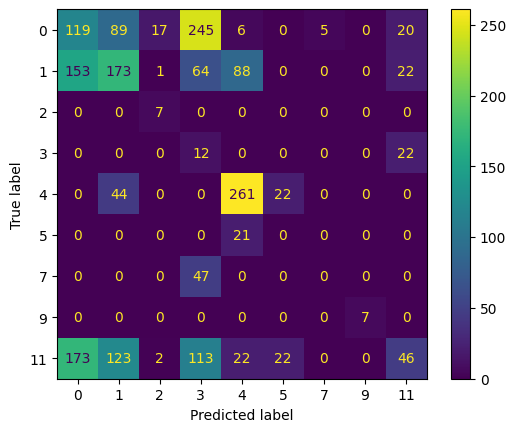

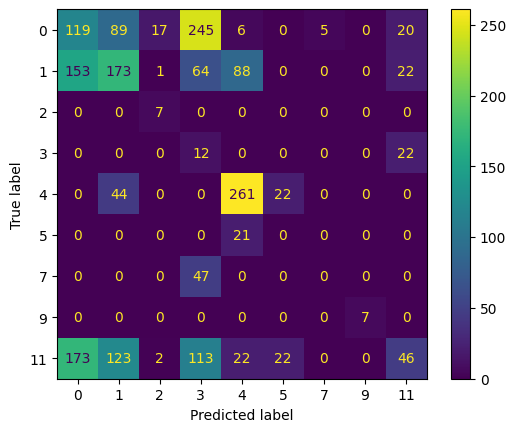

In [107]:
disp = ConfusionMatrixDisplay.from_predictions(f_dev_y, pred.argmax(axis=1))
disp.plot()